In [1]:
import numpy as np
import random as rn
import pandas as pd
import pickle
import pandas as pd
from video_process_utils import *

In [2]:
with open('./data/processed/all_videos_dict.pickle', 'rb') as handle:
    all_videos = pickle.load(handle)

In [3]:
datasplit_df = pd.read_csv('./data/processed/train_test_valid_id_split.csv')
datasplit_df['videoid'] = datasplit_df['videoid'].apply(lambda x: int(x))
all_ids = datasplit_df['videoid'].values

In [4]:
COLS_USED = [LANK,RANK,LKNE,RKNE,LHIP,RHIP,LBTO,RBTO]

In [5]:
def process_video_and_add_cols(res):
    res = res.copy()
    centered_filtered = preprocess_frames(res)
    #add columns
    ankle_knee_hip_leftangle = get_angle(LANK,LKNE,LHIP,centered_filtered)
    ankle_knee_hip_rightangle = get_angle(RANK,RKNE,RHIP,centered_filtered)
    toe_ankle_knee_leftangle = get_angle(LBTO,LANK,LKNE,centered_filtered)
    toe_ankle_knee_rightangle = get_angle(RBTO,RANK,RKNE,centered_filtered)
    toe_ankle_dist_left = get_distance(LBTO,LANK,centered_filtered)
    toe_ankle_dist_right = get_distance(RBTO,RANK,centered_filtered)
    lank_rank_xdist = centered_filtered[:,2*RANK] - centered_filtered[:,2*LANK]
    rank_lank_xdist = centered_filtered[:,2*LANK] - centered_filtered[:,2*RANK]

    for col in [ankle_knee_hip_leftangle,
                ankle_knee_hip_rightangle,
               toe_ankle_knee_leftangle,
               toe_ankle_knee_rightangle,
                toe_ankle_dist_left,
                toe_ankle_dist_right,
               lank_rank_xdist,
               rank_lank_xdist]:
        centered_filtered = np.append(centered_filtered,col.reshape(-1,1),1)
    return centered_filtered

In [6]:
vid_length = 124
processed_videos = []
processed_video_segments = []
for counter,video_id in enumerate(all_ids):
    if(counter % 100 == 0):
        print("%.2f percent done" % (counter*100./len(all_ids)))
    raw_video = all_videos[video_id]
    centered_filtered = process_video_and_add_cols(raw_video)
    processed_videos.append((video_id,centered_filtered))
    start_idx = 0
    for i in range(start_idx,500-vid_length,31):
        raw_video_chunk = raw_video[i:i+vid_length,:]
        pct_missing =\
            max_pct_nan_or_zero_given_cols(drop_confidence_cols(raw_video_chunk),COLS_USED)
        if pct_missing <= 0.25 and len(raw_video_chunk) == vid_length:
            processed_video_segments.append((video_id,i,
                                     centered_filtered[i:i+vid_length,:]))

0.00 percent done
4.52 percent done
9.04 percent done
13.56 percent done


C:\Users\dylan\Documents\cs231n\final_project\mobile-gaitlab\nature_comm_paper\video_process_utils.py:68: RuntimeWarning: invalid value encountered in double_scalars
  return np.max(np.sum(mask,axis=0))*1.0/len(A)


18.08 percent done
22.60 percent done
27.12 percent done
31.65 percent done
36.17 percent done
40.69 percent done
45.21 percent done
49.73 percent done
54.25 percent done
58.77 percent done
63.29 percent done
67.81 percent done
72.33 percent done
76.85 percent done
81.37 percent done
85.90 percent done
90.42 percent done
94.94 percent done
99.46 percent done


In [7]:
len(processed_video_segments)

25585

In [8]:
len(processed_videos)

2212

In [9]:
with open('./data/processed/all_processed_video_segments.pickle', 'wb') as handle:
    pickle.dump(processed_video_segments, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
with open('./data/processed/all_processed_videos.pickle', 'wb') as handle:
    pickle.dump(processed_videos, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
res = all_videos[list(all_videos.keys())[5]].copy()[:500]
num_parts = res.shape[1]/3
res = drop_confidence_cols(res)
res[res == 0] = np.NaN

res = impute_frames(res)
res = filter_frames(res)

mhip_x = ((res[:,2*RHIP] + res[:,2*LHIP])/2).reshape(-1,1)
mhip_y = ((res[:,2*RHIP+1] + res[:,2*LHIP+1])/2).reshape(-1,1)
mhip_coords = np.hstack([mhip_x,mhip_y]*int(num_parts))

scale_vector_R = np.apply_along_axis(lambda x: np.linalg.norm(x[topoint(RHIP)] -
                                                              x[topoint(RKNE)]),1,res)
scale_vector_L = np.apply_along_axis(lambda x: np.linalg.norm(x[topoint(LHIP)] -
                                                              x[topoint(LKNE)]),1,res)
scale_vector = ((scale_vector_R + scale_vector_L)/2.0).reshape(-1,1)

res = (res-mhip_coords)/scale_vector
#apply the sign
lt_x = res[:,2*LANK] - res[:,2*LBTO]
rt_x = res[:,2*RANK] - res[:,2*RBTO]
signal = (lt_x+rt_x)/2.0
orientation = np.where(lt_x+rt_x >= 0,1,-1).reshape(-1,1)

Text(0.5,0,'Frame')

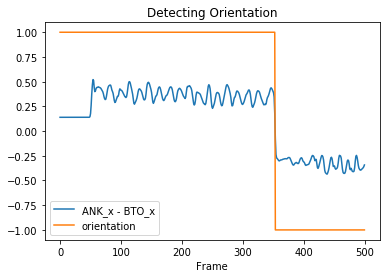

In [12]:
plt.plot(signal,label="ANK_x - BTO_x")
plt.plot(orientation,label="orientation")
plt.legend()
plt.title("Detecting Orientation")
plt.xlabel("Frame")